# Project5: Niraj 
## Accident time series 



In [517]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn import metrics 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow import keras
from tensorflow.keras.regularizers import l2


In [518]:
# Read the saved csv from the earlier notebook and set the index to the date_time column

df_accident_ts = pd.read_csv("./data/accident_ts_10years.csv", parse_dates= ['date_time'], index_col="date_time")

/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (3,6,8,11,20,24,26,28,30,32,34,36,38,40,42,44,48,50,52) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [519]:
df_accident_ts.reset_index()
df_accident_ts.sort_index(inplace=True)

In [520]:
df_accident_ts.index.isnull().sum()

0

In [521]:
# See relavant accident data 
df_accident_ts[['year', "month", "day_week", "hour", "minute", "day_3hr_window", "day_3hr_window_name", "fatals", "drunk_dr"]]


,year,month,day_week,hour,minute,day_3hr_window,day_3hr_window_name,fatals,drunk_dr
date_time,,,,,,,,,
2010-01-01 00:01:00,2010,1,6,0,1,41,NaN,1,1
2010-01-01 00:07:00,2010,1,6,0,7,41,NaN,2,2
2010-01-01 00:17:00,2010,1,6,0,17,41,NaN,1,1
2010-01-01 00:17:00,2010,1,6,0,17,41,NaN,1,1
2010-01-01 00:19:00,2010,1,6,0,19,41,NaN,1,1
...,...,...,...,...,...,...,...,...,...
2020-12-31 23:32:00,2020,12,5,23,32,40,Thursday 21:00 to 24:00,1,0
2020-12-31 23:36:00,2020,12,5,23,36,40,Thursday 21:00 to 24:00,1,0
2020-12-31 23:50:00,2020,12,5,23,50,40,Thursday 21:00 to 24:00,1,0


In [522]:
# Create new df for modeling which has the columns we need, by day 
# can do by day: 365*11 = 4000 records or by 3 hour windows = 32k records
df_model_day = df_accident_ts.resample("D").sum()[["fatals", "drunk_dr", "peds", "ve_total", "persons" ]]

In [523]:
df_model_day

,fatals,drunk_dr,peds,ve_total,persons
date_time,,,,,
2010-01-01,134,74,19,181,321
2010-01-02,61,25,9,74,117
2010-01-03,54,27,3,78,132
2010-01-04,70,13,9,104,136
2010-01-05,68,12,19,115,154
...,...,...,...,...,...
2020-12-27,98,27,21,128,201
2020-12-28,98,12,17,140,198
2020-12-29,88,16,22,126,194


In [450]:
df_model_day.describe()

,fatals,drunk_dr,peds,ve_total,persons
count,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000
mean,95.776257,25.554754,18.878795,136.674465,199.086361
std,21.590549,12.740223,6.523888,29.669771,50.223789
min,34.000000,5.000000,3.000000,45.000000,78.000000
25%,80.000000,16.000000,14.000000,115.000000,161.000000
50%,93.000000,21.500000,18.000000,135.000000,193.000000
75%,110.000000,34.000000,23.000000,156.000000,231.000000
max,184.000000,87.000000,55.000000,276.000000,429.000000


In [451]:
# Create new df for modeling which has the columns we need, by 3 hour windows 
# can do by day: 365*11 = 4000 records or by 3 hour windows = 24k records

df_model_3hour = df_accident_ts.resample("3H").sum()[["fatals", "drunk_dr", "peds", "ve_total", "persons" ]]

In [452]:
df_model_3hour.describe()

,fatals,drunk_dr,peds,ve_total,persons
count,32144.000000,32144.000000,32144.000000,32144.000000,32144.000000
mean,11.972032,3.194344,2.359849,17.084308,24.885795
std,5.901297,3.336050,2.430880,8.737559,14.190159
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,1.000000,1.000000,11.000000,14.000000
50%,11.000000,2.000000,2.000000,16.000000,23.000000
75%,15.000000,4.000000,3.000000,22.000000,33.000000
max,44.000000,32.000000,25.000000,94.000000,153.000000


### Let's Model! 


### Train test Split

In [453]:
# Create X and y
# maybe add other highly correlated cols like construction zone 
X = df_model_day.drop(columns = ['fatals'])
y = df_model_day['fatals']


In [454]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, shuffle = False) # keep in chronological order 
# smaller than we're used to; difficult to predict far out in the future 
# last 2% is our test


In [456]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3937, 4), (81, 4), (3937,), (81,))

In [457]:
# Check target mean for both train and test
y_train.mean(), y_test.mean()

(95.47320294640589, 110.50617283950618)

In [458]:
# Scale training and testing data
sc =StandardScaler()
X_train_sc =sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [460]:
# Create training sequences

# 64 sequences of len=3 fed through our model at a time
train_seq = TimeseriesGenerator( X_train_sc, y_train, length = 3, batch_size=16) 


In [461]:
X_train

,drunk_dr,peds,ve_total,persons
date_time,,,,
2010-01-01,74,19,181,321
2010-01-02,25,9,74,117
2010-01-03,27,3,78,132
2010-01-04,13,9,104,136
2010-01-05,12,19,115,154
...,...,...,...,...
2020-10-07,22,26,167,218
2020-10-08,21,22,169,216
2020-10-09,34,31,229,303


In [462]:
# Create test sequences
# one bacth of data (batch of sequences)
train_seq[0][0]


array([[[ 3.78561972,  0.04294179,  1.51767441,  2.4346476 ],
        [-0.04499528, -1.50808429, -2.10584635, -1.62303778],
        [ 0.11135636, -2.43869993, -1.97038763, -1.32467856]],

       [[-0.04499528, -1.50808429, -2.10584635, -1.62303778],
        [ 0.11135636, -2.43869993, -1.97038763, -1.32467856],
        [-0.98310507, -1.50808429, -1.08990595, -1.2451161 ]],

       [[ 0.11135636, -2.43869993, -1.97038763, -1.32467856],
        [-0.98310507, -1.50808429, -1.08990595, -1.2451161 ],
        [-1.06128089,  0.04294179, -0.71739447, -0.88708504]],

       [[-0.98310507, -1.50808429, -1.08990595, -1.2451161 ],
        [-1.06128089,  0.04294179, -0.71739447, -0.88708504],
        [-1.53033579, -1.50808429, -2.03811699, -1.88161577]],

       [[-1.06128089,  0.04294179, -0.71739447, -0.88708504],
        [-1.53033579, -1.50808429, -2.03811699, -1.88161577],
        [-0.82675344, -0.57746864, -0.34488299, -0.13124168]],

       [[-1.53033579, -1.50808429, -2.03811699, -1.88161577]

In [463]:
# First batch of target values 
train_seq[0][1]

array([70, 68, 55, 84, 61, 84, 60, 68, 76, 70, 97, 75, 81, 85, 75, 77])

In [464]:
y_train

date_time
2010-01-01    134
2010-01-02     61
2010-01-03     54
2010-01-04     70
2010-01-05     68
             ... 
2020-10-07    114
2020-10-08    115
2020-10-09    147
2020-10-10    168
2020-10-11    126
Freq: D, Name: fatals, Length: 3937, dtype: int64

In [465]:
# how many batches in the whole training set

len(train_seq)

246

In [466]:
X_train.head() # 5 columns

,drunk_dr,peds,ve_total,persons
date_time,,,,
2010-01-01,74,19,181,321
2010-01-02,25,9,74,117
2010-01-03,27,3,78,132
2010-01-04,13,9,104,136
2010-01-05,12,19,115,154


In [467]:
X_test # small percentage

,drunk_dr,peds,ve_total,persons
date_time,,,,
2020-10-12,18,21,173,229
2020-10-13,19,21,155,194
2020-10-14,15,17,175,219
2020-10-15,18,25,161,201
2020-10-16,27,39,190,265
...,...,...,...,...
2020-12-27,27,21,128,201
2020-12-28,12,17,140,198
2020-12-29,16,22,126,194


In [468]:
# Now do for test data, same len and batch_size as train data
test_seq = TimeseriesGenerator( X_test_sc, y_test, length = 3, batch_size=16) 
len(test_seq)

5

## Modeling time!
---

Now it's time to design our RNN model. We'll have:

- 2 [`GRU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) layers
- 1 `Dense` output layer

We're doing a linear regression problem

In [469]:
## Check shape of a single sequence of data (this will be the input shape for our model)

train_seq[0][0][0].shape

(3, 4)

In [508]:

#The number of hidden nodes should be somewhere between the number of nodes in the input and output layers.* 
#No of nodes in each layer should be power of 2. 


# Design RNN
model = Sequential()

## First GRU layer returns hidden state, passes back into self
model.add(GRU(16, input_shape = train_seq[0][0][0].shape, 
             return_sequences=True))
## Second GRU layer passes outputs forward to next layer
model.add(GRU(8, return_sequences=False))

model.add(Dense(8, activation = 'relu'))

model.add(Dense(1)) # output layer

model.compile(
    optimizer="adam", ## Adam is the most commonly used optimized
    loss="mean_squared_error", # or 'mse' is the most common loss function for regression
    metrics= [tf.keras.metrics.RootMeanSquaredError(),'mae', 'mape'], # Additional metrics to track - no 'rmse' so instead we can use tensorflow's RMSE function
)

In [509]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_23 (GRU)                (None, 3, 16)             1056      
                                                                 
 gru_24 (GRU)                (None, 8)                 624       
                                                                 
 dense_53 (Dense)            (None, 8)                 72        
                                                                 
 dense_54 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,761
Trainable params: 1,761
Non-trainable params: 0
_________________________________________________________________


In [510]:
# Fit to training sequences, validate with test sequences

history = model.fit(train_seq, epochs = 50, verbose = 1, validation_data=test_seq)

Epoch 1/50
246/246 [==============================] - 24s 19ms/step - loss: 9404.5654 - root_mean_squared_error: 96.9771 - mae: 94.5518 - mape: 98.9778 - val_loss: 11774.8896 - val_root_mean_squared_error: 108.5122 - val_mae: 107.0123 - val_mape: 96.5764
Epoch 2/50
246/246 [==============================] - 2s 7ms/step - loss: 8042.6094 - root_mean_squared_error: 89.6806 - mae: 87.0271 - mape: 90.7087 - val_loss: 9639.3496 - val_root_mean_squared_error: 98.1802 - val_mae: 96.5203 - val_mape: 86.8510
Epoch 3/50
246/246 [==============================] - 2s 8ms/step - loss: 6050.1768 - root_mean_squared_error: 77.7829 - mae: 74.6070 - mape: 76.9727 - val_loss: 7160.6821 - val_root_mean_squared_error: 84.6208 - val_mae: 82.6893 - val_mape: 74.0301
Epoch 4/50
246/246 [==============================] - 1s 6ms/step - loss: 4066.9292 - root_mean_squared_error: 63.7725 - mae: 59.7684 - mape: 60.5861 - val_loss: 4840.3467 - val_root_mean_squared_error: 69.5726 - val_mae: 67.2100 - val_mape: 59.

y_test_baseline: 95.47320294640589, y_train_baseline_mean: 95.47320294640589, baseline_RMSE: 23.24519113999734, baseline MAPE: 0.148302794152187, baseline MAE: 0.148302794152187 
Baseline R2 score: 0.0
Baseline Training R2 score: -0.7189155360280703
Training R2 score: 0.5302380504525666
Test R2 score: 0.27362319324258577


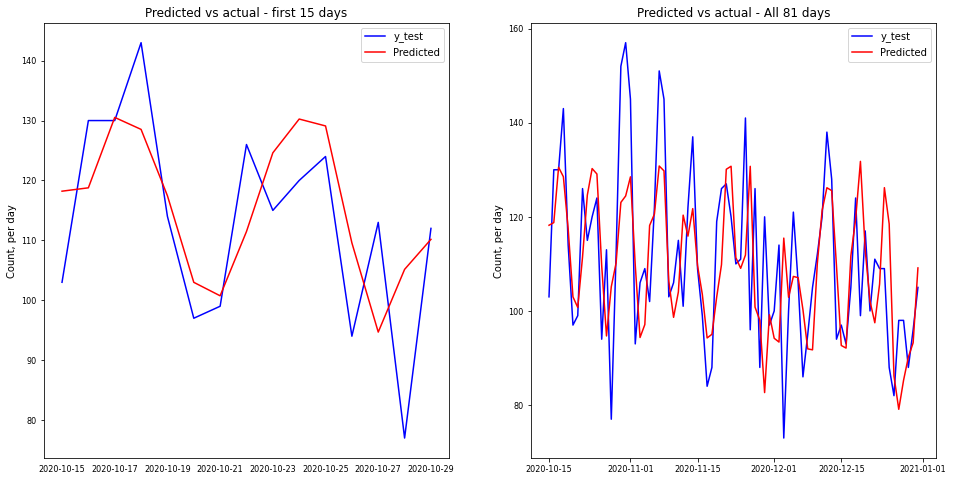

In [525]:
# Evaluate the model performance with various metrics

y_train_preds = model.predict(train_seq)
y_test_preds = model.predict(test_seq)

# baseline
y_test_baseline = [y_train.mean()]*len(y_test)

baseline_RMSE = mean_squared_error(y_test, y_test_baseline)**0.5
baseline_mean = y_train.mean()
y_train_baseline = [y_train.mean()]*len(y_train)

baseline_MAPE = mean_absolute_percentage_error(y_test, y_test_baseline)
baseline_MAE = mean_absolute_error (y_test, y_test_baseline)

print( f"y_test_baseline: {y_test_baseline[0]}, y_train_baseline_mean: {baseline_mean}, baseline_RMSE: {baseline_RMSE}, baseline MAPE: {baseline_MAPE}, baseline MAE: {baseline_MAPE} ")


print( f"Baseline R2 score: {metrics.r2_score(y_train, y_train_baseline)}" )
print( f"Baseline Training R2 score: {metrics.r2_score(y_test, y_test_baseline)}" )

print( f"Training R2 score: {metrics.r2_score( y_train[3:], y_train_preds)}")
print( f"Test R2 score: {metrics.r2_score( y_test[3:], y_test_preds[:])}") 

y_test_preds_df = pd.DataFrame(data = y_test_preds, index = y_test[3:].index, columns = ["y_test_preds"])

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,8))
labels = ['y_test', 'preds']

ax1.plot( y_test[3:18], color = 'blue', label="y_test")
ax1.plot( y_test_preds_df[:15], color = 'red', label="Predicted")
ax1.set_title("Predicted vs actual - first 15 days")
ax1.xaxis.set_ticks_position('none')
ax1.set_ylabel("Count, per day")
ax1.tick_params(labelsize=8)
ax1.legend()

ax2.plot( y_test[3:], color = 'blue', label="y_test")
ax2.plot( y_test_preds_df[:], color = 'red', label="Predicted")
ax2.set_title("Predicted vs actual - All 81 days")
ax2.set_ylabel("Count, per day")
ax2.tick_params(labelsize=8)
ax2.legend()

#### **Interpretation:**  
The predictions are quite good, more so in the first 15 days. Over the total 81 days of predictions, the predictions don't quite match the peaks. In fact, towards the end they overshoot the data considerably. 


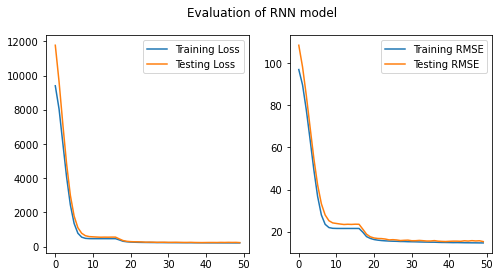

In [531]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4))

## Plot Training & Validation Loss
ax1.plot(history.history['loss'], label="Training Loss")
ax1.plot(history.history['val_loss'], label="Testing Loss")
ax1.legend();

## Plot Training & Validation Accuracy
ax2.plot(history.history['root_mean_squared_error'], label="Training RMSE")
ax2.plot(history.history['val_root_mean_squared_error'], label="Testing RMSE")
ax2.legend();

plt.suptitle("Evaluation of RNN model");

#### **Interpretation:**  
The graphs are almost perfect! The testing RMSE is marginally higher than the Training RMSE, showing the model is not overfit and should do a good job on predicting new unseen data. 

In [476]:
# change GRU to LSTM

model_2 = Sequential()

## First LSTM layer returns hidden state, passes back into self
model_2.add(LSTM(16, input_shape = train_seq[0][0][0].shape, 
             return_sequences=True))
## Second LSTM layer passes outputs forward to next layer
model_2.add(LSTM(8, return_sequences=False))

model_2.add(Dense(8, activation = 'relu'))

model_2.add(Dense(1))

model_2.compile(
    optimizer="adam",
    loss="mean_squared_error", 
    metrics= [tf.keras.metrics.RootMeanSquaredError(),'mae']
)


In [477]:
model_2.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 3, 16)             1344      
                                                                 
 lstm_27 (LSTM)              (None, 8)                 800       
                                                                 
 dense_49 (Dense)            (None, 8)                 72        
                                                                 
 dense_50 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,225
Trainable params: 2,225
Non-trainable params: 0
_________________________________________________________________


In [478]:
history_2 = model_2.fit( train_seq, epochs = 50, verbose = 1, validation_data = test_seq)

Epoch 1/50
246/246 [==============================] - 12s 10ms/step - loss: 8685.9131 - root_mean_squared_error: 93.1982 - mae: 90.5466 - val_loss: 9125.1152 - val_root_mean_squared_error: 95.5255 - val_mae: 93.8181
Epoch 2/50
246/246 [==============================] - 1s 5ms/step - loss: 4637.7485 - root_mean_squared_error: 68.1010 - mae: 64.0108 - val_loss: 4478.1860 - val_root_mean_squared_error: 66.9193 - val_mae: 64.4583
Epoch 3/50
246/246 [==============================] - 1s 5ms/step - loss: 1779.0674 - root_mean_squared_error: 42.1790 - mae: 35.9956 - val_loss: 1756.7588 - val_root_mean_squared_error: 41.9137 - val_mae: 37.8632
Epoch 4/50
246/246 [==============================] - 1s 5ms/step - loss: 679.6533 - root_mean_squared_error: 26.0702 - mae: 20.0730 - val_loss: 825.1624 - val_root_mean_squared_error: 28.7256 - val_mae: 23.4550
Epoch 5/50
246/246 [==============================] - 1s 6ms/step - loss: 480.6317 - root_mean_squared_error: 21.9233 - mae: 17.3204 - val_loss:

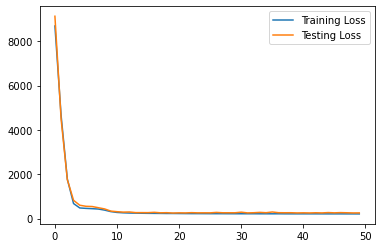

In [479]:
## Plot Training & Validation Loss
plt.plot(history_2.history['loss'], label="Training Loss")
plt.plot(history_2.history['val_loss'], label="Testing Loss")
plt.legend();

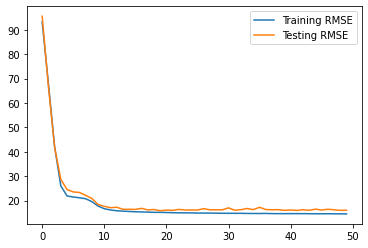

In [480]:
## Plot Training & Validation Accuracy
plt.plot(history_2.history['root_mean_squared_error'], label="Training RMSE")
plt.plot(history_2.history['val_root_mean_squared_error'], label="Testing RMSE")
plt.legend();


y_test_baseline: 95.47320294640589, y_train_baseline_mean: 95.47320294640589, baseline_RMSE: 23.24519113999734 
0.0
-0.7189155360280703
Training R2 score: 0.5452752506706826
Test R2 score: -0.5988374951471258


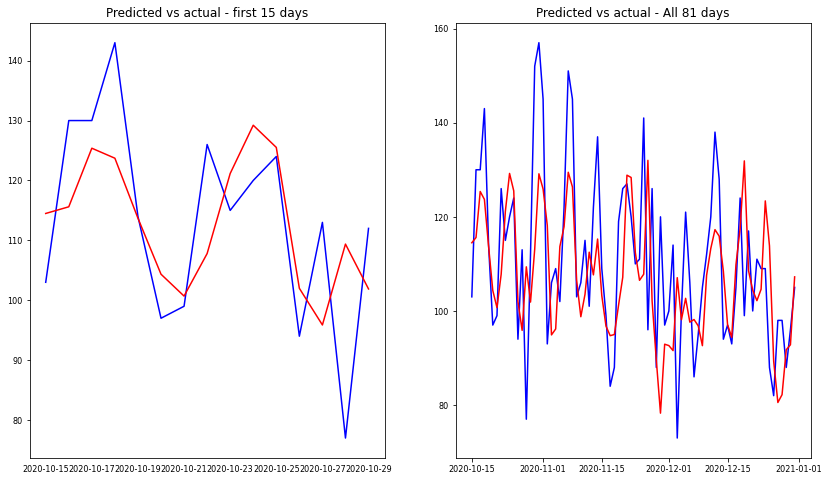

In [493]:
y_train_preds = model_2.predict(train_seq)
y_test_preds = model_2.predict(test_seq)

# baseline
y_test_baseline = [y_train.mean()]*len(y_test)

baseline_RMSE = mean_squared_error(y_test, y_test_baseline)**0.5
baseline_mean = y_train.mean()
y_train_baseline = [y_train.mean()]*len(y_train)

print( f"y_test_baseline: {y_test_baseline[0]}, y_train_baseline_mean: {baseline_mean}, baseline_RMSE: {baseline_RMSE} ")


print( metrics.r2_score(y_train, y_train_baseline) )
print( metrics.r2_score(y_test, y_test_baseline) )

print( f"Training R2 score: {metrics.r2_score( y_train[3:], y_train_preds)}")
print( f"Test R2 score: {metrics.r2_score( y_test[-15:], y_test_preds[-15:])}") # last few days 

y_test_preds_df = pd.DataFrame(data = y_test_preds, index = y_test[3:].index, columns = ["y_test_preds"])

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,8))

ax1.plot( y_test[3:18], color = 'blue')
ax1.plot( y_test_preds_df[:15], color = 'red')
ax1.set_title("Predicted vs actual - first 15 days")
ax1.xaxis.set_ticks_position('none')
ax1.tick_params(labelsize=8)

ax2.plot( y_test[3:], color = 'blue')
ax2.plot( y_test_preds_df[:], color = 'red')
ax2.set_title("Predicted vs actual - All 81 days")
ax2.tick_params(labelsize=8)


In [487]:
# 3 - RNN with LSTM and REgularization

model_3 = Sequential()

## First LSTM layer returns hidden state, passes back into self
model_3.add(LSTM(16, input_shape = train_seq[0][0][0].shape, 
             return_sequences=True))
## Second LSTM layer passes outputs forward to next layer
model_3.add(LSTM(8, return_sequences=False))

model_3.add(Dense(8, activation = 'relu', kernel_regularizer=l2(0.001)))
model_3.add(Dropout(0.2))

model_3.add(Dense(1))

model_3.compile(
    optimizer="adam",
    loss="mean_squared_error", 
    metrics= [tf.keras.metrics.RootMeanSquaredError(),'mae']
)



In [488]:
model_3.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 3, 16)             1344      
                                                                 
 lstm_29 (LSTM)              (None, 8)                 800       
                                                                 
 dense_51 (Dense)            (None, 8)                 72        
                                                                 
 dropout_13 (Dropout)        (None, 8)                 0         
                                                                 
 dense_52 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,225
Trainable params: 2,225
Non-trainable params: 0
_________________________________________________________________


In [489]:
history_3 = model_3.fit(train_seq, epochs = 40, verbose = 1, validation_data = test_seq)

Epoch 1/40
246/246 [==============================] - 13s 19ms/step - loss: 8670.5938 - root_mean_squared_error: 93.1160 - mae: 90.3603 - val_loss: 9191.1523 - val_root_mean_squared_error: 95.8704 - val_mae: 94.1688
Epoch 2/40
246/246 [==============================] - 2s 7ms/step - loss: 4992.4116 - root_mean_squared_error: 70.6568 - mae: 66.4459 - val_loss: 5122.2036 - val_root_mean_squared_error: 71.5694 - val_mae: 69.2734
Epoch 3/40
246/246 [==============================] - 1s 5ms/step - loss: 2422.7585 - root_mean_squared_error: 49.2211 - mae: 42.4195 - val_loss: 2412.9175 - val_root_mean_squared_error: 49.1210 - val_mae: 45.7127
Epoch 4/40
246/246 [==============================] - 1s 5ms/step - loss: 1220.8785 - root_mean_squared_error: 34.9403 - mae: 27.4542 - val_loss: 1201.2080 - val_root_mean_squared_error: 34.6576 - val_mae: 29.9442
Epoch 5/40
246/246 [==============================] - 1s 4ms/step - loss: 956.0872 - root_mean_squared_error: 30.9196 - mae: 24.5000 - val_los

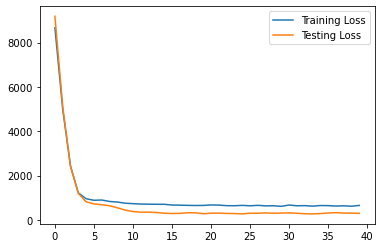

In [490]:
## Plot Training & Validation Loss
plt.plot(history_3.history['loss'], label="Training Loss")
plt.plot(history_3.history['val_loss'], label="Testing Loss")
plt.legend();

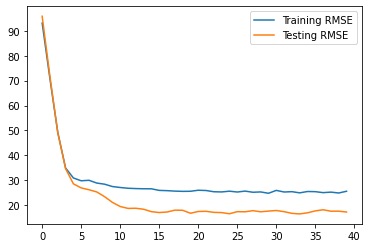

In [491]:
## Plot Training & Validation Accuracy
plt.plot(history_3.history['root_mean_squared_error'], label="Training RMSE")
plt.plot(history_3.history['val_root_mean_squared_error'], label="Testing RMSE")
plt.legend();


In [492]:
model_3.evaluate(test_seq)

5/5 [==============================] - 0s 3ms/step - loss: 297.3396 - root_mean_squared_error: 17.2408 - mae: 13.7187


[297.3396301269531, 17.24078369140625, 13.718729972839355]

In [365]:
# try with len and batch_size change

# 32 sequences of len=5 fed through our model at a time
train_seq2 = TimeseriesGenerator( X_train_sc, y_train, length = 5, batch_size=16) 
test_seq2 = TimeseriesGenerator( X_test_sc, y_test, length = 5, batch_size=16) 




In [366]:
# baseline
y_test_baseline = [y_train.mean()]*len(y_test)

baseline_RMSE = mean_squared_error(y_test, y_test_baseline)**0.5
baseline_mean = y_train.mean()

print( f"y_test_baseline: {y_test_baseline[0]}, y_train_baseline_mean: {baseline_mean}, baseline_RMSE: {baseline_RMSE} ")

#metrics.r2_score()

In [367]:
print( f"y_test_baseline: {y_test_baseline[0]}, y_train_baseline_mean: {baseline_mean}, baseline_RMSE: {baseline_RMSE} ")



y_test_baseline: 95.47320294640589, y_train_baseline_mean: 95.47320294640589, baseline_RMSE: 23.24519113999734 


In [368]:
# Design RNN - Using LSTM layerxs & Regularization
model_4 = Sequential()

model_4.add(LSTM(16, input_shape = train_seq2[0][0][0].shape,
              return_sequences=True)) ## First LSTM layer returns hidden state, passes back into self
model_4.add(LSTM(8, return_sequences=False)) ## Second LSTM layer passes outputs forward to next layer

model_4.add(Dense(8, activation = 'relu', kernel_regularizer=l2(0.001)))
model_4.add(Dropout(0.2))
model_4.add(Dense(1))

model_4.compile(
    optimizer="adam",
    loss="mean_squared_error", 
    metrics= [tf.keras.metrics.RootMeanSquaredError(),'mae']
)

model_4.summary()


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 5, 16)             1344      
                                                                 
 lstm_25 (LSTM)              (None, 8)                 800       
                                                                 
 dense_41 (Dense)            (None, 8)                 72        
                                                                 
 dropout_10 (Dropout)        (None, 8)                 0         
                                                                 
 dense_42 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,225
Trainable params: 2,225
Non-trainable params: 0
_________________________________________________________________


In [369]:
EarlyStopping(monitor = "val_root_mean_squared_error", mode = "min", verbose = 1, patience = 20, restore_best_weights=True)


In [370]:
history_4 = model_4.fit(train_seq2, epochs = 40, verbose = 1, validation_data = test_seq2)

Epoch 1/40
246/246 [==============================] - 27s 10ms/step - loss: 8833.5557 - root_mean_squared_error: 93.9870 - mae: 91.3816 - val_loss: 9931.2930 - val_root_mean_squared_error: 99.6558 - val_mae: 98.0059
Epoch 2/40
246/246 [==============================] - 1s 6ms/step - loss: 5644.6938 - root_mean_squared_error: 75.1310 - mae: 71.4254 - val_loss: 5792.4077 - val_root_mean_squared_error: 76.1077 - val_mae: 73.9352
Epoch 3/40
246/246 [==============================] - 1s 6ms/step - loss: 2796.6746 - root_mean_squared_error: 52.8832 - mae: 46.7495 - val_loss: 2775.8523 - val_root_mean_squared_error: 52.6859 - val_mae: 49.4960
Epoch 4/40
246/246 [==============================] - 2s 7ms/step - loss: 1393.7609 - root_mean_squared_error: 37.3324 - mae: 29.6617 - val_loss: 1340.4990 - val_root_mean_squared_error: 36.6120 - val_mae: 32.0455
Epoch 5/40
246/246 [==============================] - 2s 6ms/step - loss: 954.3629 - root_mean_squared_error: 30.8918 - mae: 24.2967 - val_los

In [371]:
model_4.evaluate(test_seq2)

5/5 [==============================] - 0s 2ms/step - loss: 279.6694 - root_mean_squared_error: 16.7206 - mae: 13.4663


[279.6694030761719, 16.720598220825195, 13.466326713562012]

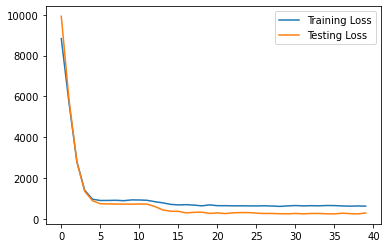

In [372]:
## Plot Training & Validation Loss
plt.plot(history_4.history['loss'], label="Training Loss")
plt.plot(history_4.history['val_loss'], label="Testing Loss")
plt.legend();

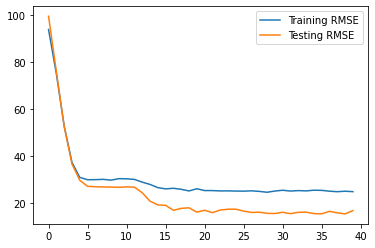

In [373]:
## Plot Training & Validation Accuracy
plt.plot(history_4.history['root_mean_squared_error'], label="Training RMSE")
plt.plot(history_4.history['val_root_mean_squared_error'], label="Testing RMSE")
plt.legend();


In [374]:
model_5 = Sequential()

model_5.add(GRU(128, input_shape = train_seq2[0][0][0].shape, return_sequences=True))
model_5.add(GRU(64, return_sequences=True))
model_5.add(GRU(32, return_sequences=False))

model_5.add(Dense(32, activation = "relu"))
model_5.add(Dropout(0.2))
model_5.add(Dense(16, activation = "relu"))
model_5.add(Dropout(0.2))
model_5.add(Dense(8,  activation = "relu"))
model_5.add(Dense(1))

model_5.compile(
    optimizer="adam",
    loss="mean_squared_error", 
    metrics= [tf.keras.metrics.RootMeanSquaredError(),'mae']
)

model_5.summary()


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_18 (GRU)                (None, 5, 128)            51456     
                                                                 
 gru_19 (GRU)                (None, 5, 64)             37248     
                                                                 
 gru_20 (GRU)                (None, 32)                9408      
                                                                 
 dense_43 (Dense)            (None, 32)                1056      
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_44 (Dense)            (None, 16)                528       
                                                                 
 dropout_12 (Dropout)        (None, 16)              

In [375]:
callbacks = [
    EarlyStopping(monitor = "val_root_mean_squared_error", mode = "min", verbose = 1, patience = 20, restore_best_weights=True),
    ModelCheckpoint("model_checkpoint.keras", save_best_only=True, monitor = "val_root_mean_squared_error", mode = "min")
]

history_5 = model_5.fit(train_seq2, epochs = 100, verbose = 1, validation_data = test_seq2,
                        callbacks = callbacks)

Epoch 1/100
246/246 [==============================] - 9s 13ms/step - loss: 3069.5574 - root_mean_squared_error: 55.4036 - mae: 42.8264 - val_loss: 802.9247 - val_root_mean_squared_error: 28.3359 - val_mae: 23.0089
Epoch 2/100
246/246 [==============================] - 2s 9ms/step - loss: 846.7835 - root_mean_squared_error: 29.0995 - mae: 23.3334 - val_loss: 771.1726 - val_root_mean_squared_error: 27.7700 - val_mae: 22.4449
Epoch 3/100
246/246 [==============================] - 2s 8ms/step - loss: 849.8469 - root_mean_squared_error: 29.1521 - mae: 23.1413 - val_loss: 556.5012 - val_root_mean_squared_error: 23.5903 - val_mae: 18.1354
Epoch 4/100
246/246 [==============================] - 2s 9ms/step - loss: 768.1182 - root_mean_squared_error: 27.7149 - mae: 21.9933 - val_loss: 675.9998 - val_root_mean_squared_error: 26.0000 - val_mae: 20.6199
Epoch 5/100
246/246 [==============================] - 2s 9ms/step - loss: 789.5966 - root_mean_squared_error: 28.0998 - mae: 22.3001 - val_loss: 

#### Epoch 30 has the best scores: 
Epoch 30/100
- 2s 18ms/step - loss: 386.9055 - root_mean_squared_error: 19.6699 - mae: 15.4310 - val_loss: 449.8936 - val_root_mean_squared_error: 21.2107 - val_mae: 16.7633



In [376]:
y_train

date_time
2010-01-01    134
2010-01-02     61
2010-01-03     54
2010-01-04     70
2010-01-05     68
             ... 
2020-10-07    114
2020-10-08    115
2020-10-09    147
2020-10-10    168
2020-10-11    126
Freq: D, Name: fatals, Length: 3937, dtype: int64

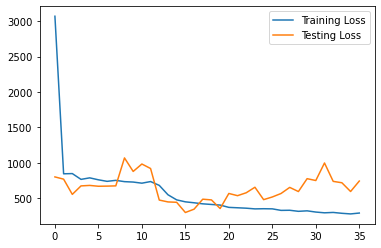

In [377]:
## Plot Training & Validation Loss
plt.plot(history_5.history['loss'], label="Training Loss")
plt.plot(history_5.history['val_loss'], label="Testing Loss")
plt.legend();

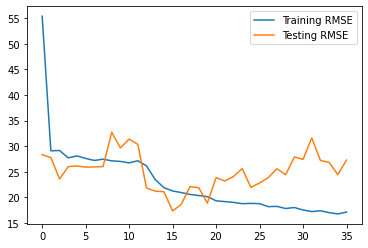

In [378]:
## Plot Training & Validation Accuracy
plt.plot(history_5.history['root_mean_squared_error'], label="Training RMSE")
plt.plot(history_5.history['val_root_mean_squared_error'], label="Testing RMSE")
plt.legend();


In [379]:
# 32 sequences of len=5 fed through our model at a time
#train_seq2 = TimeseriesGenerator( X_train_sc, y_train, length = 5, batch_size=16) 
#test_seq2 = TimeseriesGenerator( X_test_sc, y_test, length = 5, batch_size=16) 


In [380]:
y_train

date_time
2010-01-01    134
2010-01-02     61
2010-01-03     54
2010-01-04     70
2010-01-05     68
             ... 
2020-10-07    114
2020-10-08    115
2020-10-09    147
2020-10-10    168
2020-10-11    126
Freq: D, Name: fatals, Length: 3937, dtype: int64

In [381]:
model_5.evaluate(test_seq2)


5/5 [==============================] - 0s 5ms/step - loss: 300.7417 - root_mean_squared_error: 17.3419 - mae: 13.7503


[300.7417297363281, 17.341907501220703, 13.750338554382324]

In [382]:
y_train[5:].head(20)

date_time
2010-01-06    55
2010-01-07    84
2010-01-08    61
2010-01-09    84
2010-01-10    60
2010-01-11    68
2010-01-12    76
2010-01-13    70
2010-01-14    97
2010-01-15    75
2010-01-16    81
2010-01-17    85
2010-01-18    75
2010-01-19    77
2010-01-20    61
2010-01-21    71
2010-01-22    69
2010-01-23    89
2010-01-24    67
2010-01-25    70
Freq: D, Name: fatals, dtype: int64

In [383]:
train_seq2[0][1] # y_train - batch of 32 - doesn't have first 5 from y_train

array([55, 84, 61, 84, 60, 68, 76, 70, 97, 75, 81, 85, 75, 77, 61, 71])

In [385]:
y_train_preds = model_5.predict(train_seq2)
y_test_preds = model_5.predict(test_seq2)



In [386]:
# Make predictions 
# R2 scores are not releavnt for RNN - source... Roy

print( f"Training R2 score: {metrics.r2_score( y_train[5:], y_train_preds)}")
print( f"Test R2 score: {metrics.r2_score( y_test[-15:], y_test_preds[-15:])}") # last few days 

#print( f"Test R2 score: {metrics.r2_score( y_test[5:], y_test_preds)}")



Training R2 score: 0.48344758608475324
Test R2 score: -0.21425832218373286


In [387]:
y_train_preds = model_5.predict(train_seq2)
y_test_preds = model_5.predict(test_seq2)

# baseline
y_test_baseline = [y_train.mean()]*len(y_test)

baseline_RMSE = mean_squared_error(y_test, y_test_baseline)**0.5
baseline_mean = y_train.mean()
y_train_baseline = [y_train.mean()]*len(y_train)

print( metrics.r2_score(y_train, y_train_baseline) )
print( metrics.r2_score(y_test, y_test_baseline) )

print( f"Training R2 score: {metrics.r2_score( y_train[5:], y_train_preds)}")
print( f"Test R2 score: {metrics.r2_score( y_test[-15:], y_test_preds[-15:])}") # last few days 

y_test_preds_df = pd.DataFrame(data = y_test_preds, index = y_test[5:].index, columns = ["y_test_preds"])

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,8))

ax1.plot( y_test[-15:], color = 'blue')
ax1.plot( y_test_preds_df[-15:], color = 'red')
ax1.set_title("Predicted vs actual - last 15 days")
ax1.xaxis.set_ticks_position('none')
ax1.tick_params(labelsize=8)

ax2.plot( y_test[5:], color = 'blue')
ax2.plot( y_test_preds_df[:], color = 'red')
ax2.set_title("Predicted vs actual - All 81 days")
ax2.tick_params(labelsize=8)


0.0
-0.7189155360280703


In [388]:
test_seq2[0][0][0]

array([[-0.59222599,  0.35314701,  1.24675697,  0.60471106],
       [-0.51405017,  0.35314701,  0.63719273, -0.09146045],
       [-0.82675344, -0.26726342,  1.31448633,  0.40580491],
       [-0.59222599,  0.97355744,  0.84038081,  0.04777385],
       [ 0.11135636,  3.14499395,  1.82245653,  1.32077319]])

In [389]:
y_test

date_time
2020-10-12    116
2020-10-13    101
2020-10-14     99
2020-10-15    103
2020-10-16    130
             ... 
2020-12-27     98
2020-12-28     98
2020-12-29     88
2020-12-30     96
2020-12-31    105
Freq: D, Name: fatals, Length: 81, dtype: int64

In [390]:
y_test[2]



99

In [391]:
model_5.evaluate(test_seq2) 


5/5 [==============================] - 0s 3ms/step - loss: 300.7417 - root_mean_squared_error: 17.3419 - mae: 13.7503


[300.7417297363281, 17.341907501220703, 13.750338554382324]

In [392]:
y_test[5:]

date_time
2020-10-17    130
2020-10-18    143
2020-10-19    114
2020-10-20     97
2020-10-21     99
             ... 
2020-12-27     98
2020-12-28     98
2020-12-29     88
2020-12-30     96
2020-12-31    105
Freq: D, Name: fatals, Length: 76, dtype: int64

In [393]:
#print( len(y_test_preds), len(y_test[5:]))


y_test_preds_df = pd.DataFrame(data = y_test_preds, index = y_test[5:].index, columns = ["y_test_preds"])

y_test_preds_df.head()


,y_test_preds
date_time,
2020-10-17,114.250435
2020-10-18,113.864861
2020-10-19,105.615967
2020-10-20,98.090332
2020-10-21,98.508438


In [403]:
y_test_preds_df['y_test_preds']

date_time
2020-10-17    114.250435
2020-10-18    113.864861
2020-10-19    105.615967
2020-10-20     98.090332
2020-10-21     98.508438
                 ...    
2020-12-27     80.893692
2020-12-28     81.862923
2020-12-29     84.538361
2020-12-30     87.878189
2020-12-31     99.274628
Freq: D, Name: y_test_preds, Length: 76, dtype: float32

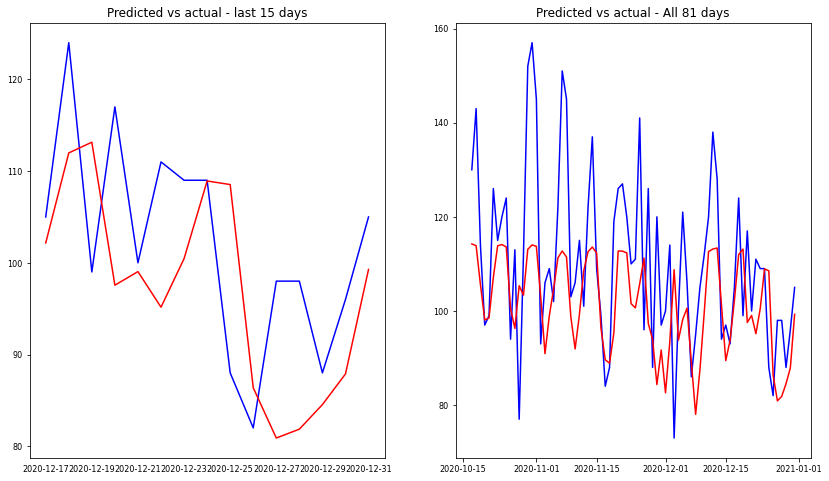

In [442]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,8))

ax1.plot( y_test[-15:], color = 'blue')
ax1.plot( y_test_preds_df[-15:], color = 'red')
ax1.set_title("Predicted vs actual - last 15 days")
ax1.xaxis.set_ticks_position('none')
ax1.tick_params(labelsize=8)

ax2.plot( y_test[5:], color = 'blue')
ax2.plot( y_test_preds_df[:], color = 'red')
ax2.set_title("Predicted vs actual - All 81 days")
ax2.tick_params(labelsize=8)


#### **Interpretation** : 
The predictions are accurate only for a short interval 

In [424]:
y_test

date_time
2020-10-12    116
2020-10-13    101
2020-10-14     99
2020-10-15    103
2020-10-16    130
             ... 
2020-12-27     98
2020-12-28     98
2020-12-29     88
2020-12-30     96
2020-12-31    105
Freq: D, Name: fatals, Length: 81, dtype: int64

In [397]:
history_5.history.keys()



dict_keys(['loss', 'root_mean_squared_error', 'mae', 'val_loss', 'val_root_mean_squared_error', 'val_mae'])

In [144]:
# Make predictions 

#y_train_preds = gs_nn2.predict(X_train_sc)
#y_test_preds = gs_nn2.predict(X_test_sc)

#print( f"Training R2 score: {metrics.r2_score( y_train, y_train_preds)}")
#print( f"Test R2 score: {metrics.r2_score( y_test, y_test_preds)}")


In [ ]:
plt.plot(history1.history['val_loss'], label='Validation MSE')
plt.plot(history1.history['loss'], label='Training MSE')
plt.legend();

In [ ]:
import tensorboard
import datetime
tensorboard.__version__

%load_ext tensorboard
logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)  

history = model3.fit(
    X_train_sc, 
    y_train, 
    validation_data = (X_test_sc, y_test),
    batch_size=64, 
    epochs=50, 
    callbacks=[tb_callback]
)

%tensorboard --logdir logs/fit


